## Debug: Convective/Stratiform Mask Module Testing. 

**Fix the CS mask module using 20051025 Hurricane Wilma case.**

**Output the Convective/Stratiform (C/S) Mask information to CONUS dBZ data.**

**For [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/).**

**Hungjui Yu – 20211217**

In [13]:
import sys
# from shutil import copyfile
import time
import datetime as dt
import pytz
from netCDF4 import (Dataset, MFDataset)
import numpy as np
import scipy.ndimage as ndi
import xarray as xr
import pandas as pd
# import geopandas as gpd
import wrf
# from wrf import (getvar, vinterp, interplevel, extract_times, destagger, to_np, latlon_coords, get_cartopy,
#                  cartopy_xlim, cartopy_ylim)

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import matplotlib as mpl
import matplotlib.pyplot as plt

# import conv_stra_sep as cs_sep

# modules_path = '/glade/work/hungjui/Research_Test/WRF_dBZ_Cloud_Classification/WRF_dBZ_Class_CONUS1/Modules'
# if ( modules_path not in sys.path ):
#     sys.path = [modules_path] + sys.path
#     # print(sys.path)
    
# import conv_stra_mask as csm

**Set input files paths and names:**

In [14]:
def set_input_names(file_date):

    file_path_1_conus = '/gpfs/fs1/collections/rda/data/ds612.0'
    file_path_1_dbz = '/glade/scratch/hungjui/DATA_WRF_CONUS_1_dBZ_v1.0'
    file_path_2 = '/' + wrf_sim_type # '/CTRL3D'
    file_path_3 = '/{}'.format(file_date.strftime('%Y'))

    file_names = dict( dbz = file_path_1_dbz
                           + file_path_2 
                           # + '/20130913'
                           # + '/20110427'
                           + '/20051025'
                           # + file_path_3 
                           + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_dbz_{}.nc'.format(file_date.strftime('%Y%m%d'))
                       # , Z = file_path_1 
                       #     + file_path_2 
                       #     + file_path_3 
                       #     + '/wrf3d_d01_' + wrf_sim_type[0:-2] + '_Z_{}.nc'.format(file_date.strftime('%Y%m%d'))
                     )
    
    return file_names

**Functions: Conv./Stra. Separation:**

In [15]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    
    re = 6371.0
    
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return c * re


In [16]:
def mask_conv_area_C(bkgnd_range_id, outarray, latarray, lonarray, grid_res, dist_thresh, assign_value):
    
    ## Set the Box Size for processing speed:
    ## The box_size should be at least 5-km by the grid_res according to SHY95.
    box_size = np.ceil((5/(grid_res*110)))
    box_size = int(box_size)
    
    ## Loop through each Convective Center:
    for ii in range(0, len(bkgnd_range_id[0])):
        
        ## Get the Lat/Lon for the Convective Center:
        lat_ind = bkgnd_range_id[0][ii]
        lon_ind = bkgnd_range_id[1][ii]
        
        lat1 = latarray[lat_ind, lon_ind]
        lon1 = lonarray[lat_ind, lon_ind]

        ## Get just the box area (box_size) surrounding the Convective Center:
        i_lat_min = np.max([0, lat_ind-box_size])
        i_lat_max = np.min([latarray.shape[0], lat_ind+box_size])

        i_lon_min = np.max([0, lon_ind-box_size])
        i_lon_max = np.min([lonarray.shape[1], lon_ind+box_size])

        lat2 = latarray[i_lat_min:i_lat_max+1, i_lon_min:i_lon_max+1]
        lon2 = lonarray[i_lat_min:i_lat_max+1, i_lon_min:i_lon_max+1]

        ## Calculate the array of distance (in the box) to the convective center:
        d = haversine(lat1, lon1, lat2, lon2)

        ## Mask the surrounding Convective Area according to the distance threshold:
        close_d = np.where(d <= dist_thresh)
        
        if len(close_d[0]):
            close_d_global = ( close_d[0] + lat_ind - box_size
                             , close_d[1] + lon_ind - box_size
                             )
            outarray[close_d_global] = assign_value

    return outarray


In [17]:
def pythagorean_dist(loc_id_x, loc_id_y, grid_length):
    """
    Calculate the distance between two points by their location id
    based on the Pythagorean Theorem on Euclidean (plain) geometry.
    """
    return np.sqrt( (loc_id_x*grid_length)**2 + (loc_id_y*grid_length)**2 )
    

In [18]:
def mask_conv_area_L(bkgnd_range_id, outarray, grid_res, dist_thresh, assign_value):
    
    ## Initialize the location id arrays for Lat/Lon grids:
    locid_lat_0 = np.tile(np.arange(outarray.shape[0]),(outarray.shape[1],1))
    locid_lat_0 = np.transpose(locid_lat_0)
    locid_lon_0 = np.tile(np.arange(outarray.shape[1]),(outarray.shape[0],1))
    
    ## Set the Box Size for processing speed:
    ## The box_size should be at least 5-km by the grid_res according to SHY95.
    box_size = np.ceil(5/grid_res)
    box_size = int(box_size)
    
    ## Loop through each Convective Center:
    for ii in range(0, len(bkgnd_range_id[0])):
        
        ## Get the location id for the Convective Center:
        locid_lat = bkgnd_range_id[0][ii]
        locid_lon = bkgnd_range_id[1][ii]
        
        ## Adjust the location id arrays by setting the id for Convective Center as (0, 0):
        # locid_lat_adj = locid_lat_0 - locid_lat
        # locid_lon_adj = locid_lon_0 - locid_lon
        
        ## Get just the box area (box_size) surrounding the Convective Center:
        i_locid_lat_min = np.max([0, locid_lat-box_size])
        i_locid_lat_max = np.min([locid_lat_0.shape[0], locid_lat+box_size])

        i_locid_lon_min = np.max([0, locid_lon-box_size])
        i_locid_lon_max = np.min([locid_lon_0.shape[1], locid_lon+box_size])
        
        # locid_lat_box = locid_lat_adj[i_locid_lat_min:i_locid_lat_max+1, i_locid_lon_min:i_locid_lon_max+1] 
        # locid_lon_box = locid_lon_adj[i_locid_lat_min:i_locid_lat_max+1, i_locid_lon_min:i_locid_lon_max+1] 
        
        locid_lat_box_2 = locid_lat_0[i_locid_lat_min:i_locid_lat_max+1, i_locid_lon_min:i_locid_lon_max+1] - locid_lat
        locid_lon_box_2 = locid_lon_0[i_locid_lat_min:i_locid_lat_max+1, i_locid_lon_min:i_locid_lon_max+1] - locid_lon
        
        ## Calculate the array of distance (in the box) to the convective center:
        # dist_arr = np.sqrt( (locid_lat_adj*grid_res)**2 + (locid_lon_adj*grid_res)**2 )
        # dist_arr = np.sqrt( (locid_lat_box*grid_res)**2 + (locid_lon_box*grid_res)**2 )
        
        dist_arr = pythagorean_dist(locid_lat_box_2, locid_lon_box_2, grid_res)

        ## Mask the surrounding Convective Area according to the distance threshold:
        close_dist = np.where(dist_arr <= dist_thresh)
        
        if len(close_dist[0]):
            close_dist_global = ( close_dist[0] + locid_lat - box_size
                                , close_dist[1] + locid_lon - box_size
                                )
            outarray[close_dist_global] = assign_value

    return outarray
    

In [19]:
import os

def conv_stra_sep(dbz, lat2d, lon2d, grid_res, coor_type, method, CoreThresh=40.0, tune_thresh=42.43, bg_diff=10, fill_dbz=0.0):
    
    ## Function arguments settings:
    # coor_type = 'C' if coor_type is None else coor_type 
    # method = 'SHY' if method is None else method
    assert coor_type in ['C', 'L'] # make sure the coordinates type is either "C"artesian or "L"ambert-conformal.
    assert method in ['SHY', 'YH'] # make sure the method is either SHY or YH
    
    ## Initialize the mask fields:
    cs = np.full_like(dbz, np.nan) # Conv./Stra. Mask.
    # cc = np.zeros_like(cs) - 1     # Convective Centers.
    
    ## Set good/bad data booleans:
    ## The bad indicates missing dBZ data points or dBZ <= 0 
    ## (The smallest dBZ in models runs is -30.0; and the dBZ is simulated as S-band radar(?)):
    boo_bad = ((dbz == np.nan) | (dbz <= 0.0))
    boo_good = np.logical_not(boo_bad)
    
    ## Set the Conv./Stra. Masks anywhere data is good and dBZ greater than 15 dBZ (YH97, 98), give it a 0.
    ## 0 is stratiform:
    cs[((boo_good) & (dbz >= 15.0))] = 0
    
    ## Fill the missing grids with specified dBZ values:
    dbz[boo_bad] = fill_dbz
    
    ## Calculate linear reflectivity:
    zlin = 10.**(dbz/10.)

    ## Calculate a smoothed (averaged) background reflectivity field using a filter:
    ## According to SHY95, a 11-km radius circle was used to mimic the 400-km^2 area from Churchill and Houze (1984).
    ## Herein, we directly use the 20-km length (sqrt(400)) divided by the grid_res (4-km in this case) for the filter size.
    
    # bkgnd_lin = ndi.median_filter(zlin, size=, mode='nearest')
    bkgnd_lin = ndi.uniform_filter(zlin, size=20/grid_res, mode='nearest')
    
    bkgnd = 10.*np.log10(bkgnd_lin)
    bkgnd[boo_bad] = fill_dbz
        
    ## Convective Centers identification 1: Intensity (SHY95):
    cc = np.where( (dbz >= CoreThresh), 1, -1 )
    
    ## Convective Centers identification 2: Peakedness (SHY95):
    ## (a): Function (2) top in SHY95.
    
    CCI2a = (bkgnd < 0.) & ((dbz - bkgnd) >= bg_diff)
    cc[CCI2a] = 21

    ## Convective Centers identification 2: Peakedness (SHY95):
    ## (b): Function (2) middle in SHY95.
    
    if method == 'SHY':
        CCI2b = (bkgnd >= 0.) & (bkgnd < tune_thresh) & (dbz-bkgnd >= (bg_diff-(bkgnd**2.)/180.))
    elif method == 'YH':
        # This line uses YH (1998) climatological tuning algorithm (a=10, b=100):
        CCI2b = (bkgnd >= 0.) & (bkgnd < tune_thresh) & (dbz-bkgnd > 10.*np.cos((np.pi*bkgnd)/(2.*100.)))
    else:
        raise ValueError('The method is not defined!')

    cc[CCI2b] = 22
    
    ## Convective Centers identification 2: Peakedness (SHY95):
    ## (c): Function (2) bottom in SHY95.

    CCI2c = (bkgnd >= tune_thresh)
    cc[CCI2c] = 23

    ## Convective Centers identification 3: Surrounding area (SHY95):
    ## Use the medium relation as in Fig.6b of SHY95.
    
    if coor_type == 'C':
    
        bkgnd_range_id = np.where((cc > 0) & (bkgnd <= 25.))    
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_C(bkgnd_range_id, cs, lat2d, lon2d, grid_res, 1.0, 1)
            # cs[bkgnd_range_id] = 1

        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 25.) & (bkgnd <= 30.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_C(bkgnd_range_id, cs, lat2d, lon2d, grid_res, 2.0, 2)
            # cs[bkgnd_range_id] = 2

        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 30.) & (bkgnd <= 35.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_C(bkgnd_range_id, cs, lat2d, lon2d, grid_res, 3.0, 3)
            # cs[bkgnd_range_id] = 3

        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 35.) & (bkgnd <= 40.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_C(bkgnd_range_id, cs, lat2d, lon2d, grid_res, 4.0, 4)
            # cs[bkgnd_range_id] = 4

        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 40.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_C(bkgnd_range_id, cs, lat2d, lon2d, grid_res, 5.0, 5)
            # cs[bkgnd_range_id] = 5
    
    elif coor_type == 'L':
        
        bkgnd_range_id = np.where((cc > 0) & (bkgnd <= 25.))    
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_L(bkgnd_range_id, cs, grid_res, 1.0, 1)

        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 25.) & (bkgnd <= 30.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_L(bkgnd_range_id, cs, grid_res, 2.0, 2)
            
        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 30.) & (bkgnd <= 35.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_L(bkgnd_range_id, cs, grid_res, 3.0, 3)
            
        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 35.) & (bkgnd <= 40.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_L(bkgnd_range_id, cs, grid_res, 4.0, 4)
            
        bkgnd_range_id = np.where((cc > 0) & (bkgnd > 40.))
        if len(bkgnd_range_id[0]):
            cs = mask_conv_area_L(bkgnd_range_id, cs, grid_res, 5.0, 5)
                        
    else:
        raise ValueError('The coordinates type is not defined!')
        
        
    return cs, cc, bkgnd


### Main Testing:

In [20]:
start = time.time()


## WRF Model Simulation Category:
wrf_sim_type = 'CTRL3D'
# wrf_sim_type = 'PGW3D'

# dayi = dt.datetime(2013, 9, 13, 0, 0, 0, tzinfo=pytz.utc)
# dayi = dt.datetime(2011, 4, 27, 0, 0, 0, tzinfo=pytz.utc)
dayi = dt.datetime(2005, 10, 25, 0, 0, 0, tzinfo=pytz.utc)

## Set input files paths and names:
file_name_dict = set_input_names(dayi)

## Open dBZ data array and append calculated data:
ds_wrf_dbz = xr.open_dataset(file_name_dict['dbz'])

## Get dBZ data:
da_wrf_dbz = ds_wrf_dbz['dBZ'].isel(Time=0)

## Get dBZ data at specified sigma level:
dbz_sigmalev = da_wrf_dbz[12,:,:]

## Convective/Stratiform Separation:
## !!! Make sure the array for the masking is in numpy array format (speed issue) !!!
CS_mask_single, Conv_Cent, Background_REFL = conv_stra_sep( dbz_sigmalev.data, dbz_sigmalev.XLAT.data, dbz_sigmalev.XLONG.data, 4, 'L', 'SHY' )

CS_mask_single[np.where(dbz_sigmalev.data <= 0.0)] = np.nan
CS_mask_single[np.where(np.isnan(dbz_sigmalev.data))] = -1

CS_mask = CS_mask_single

ds_wrf_dbz['CS_mask'] = (['south_north', 'west_east'], CS_mask)
ds_wrf_dbz.close()
    
end = time.time()

print("RUNTIME：%f SEC" % (end - start))
print("RUNTIME：%f MIN" % ((end - start)/60))
print("RUNTIME：%f HOUR" % ((end - start)/3600))
    

RUNTIME：0.638427 SEC
RUNTIME：0.010640 MIN
RUNTIME：0.000177 HOUR


In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [218]:
# print(type(dbz_sigmalev.data))
# isinstance(dbz_sigmalev.data, np.ma.masked_array)
# bad = (dbz_sigmalev.data == np.nan)
# print(bad)
# dbz_sigmalev[np.where(bad)] = 0
# print(dbz_sigmalev.XLAT.shape)

In [217]:
# print(dbz_sigmalev.shape[0])
# print(np.arange(dbz_sigmalev.shape[1]))
# locid_lon_0 = np.tile(np.arange(dbz_sigmalev.shape[1]),(dbz_sigmalev.shape[0],1))
# print(locid_lon_0)

# locid_lat_0 = np.tile(np.arange(dbz_sigmalev.shape[0]),(dbz_sigmalev.shape[1],1))
# locid_lat_0 = np.transpose(locid_lat_0)
# oooppp = locid_lat_0**2
# print(oooppp.shape)

# print(np.ceil(5/2).astype(int))

<font color='teal'>**Supplement Codes:**</font>

**Function: creating new map:**

In [21]:
def new_map(fig):
    
    # proj = ccrs.LambertConformal()
    proj = ccrs.PlateCarree(central_longitude=0)
    
    # ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax = plt.axes(projection=proj)
    
    ## Set extent:
    # ax.set_global()
    
    ## CONUS:
    ax.set_extent([-139, -55, 16, 60], crs=proj)    
    ## 9/13 case:
    # ax.set_extent([-115, -95, 32, 43], crs=proj)    
    ## 4/27 case:
    # ax.set_extent([-96, -84, 33, 41], crs=proj)
    ## Test:
    # ax.set_extent([-86, -76, 25, 33], crs=proj)
    ax.set_extent([-86, -65, 25, 45], crs=proj)
    
    ## Add coast lines:
    ax.coastlines('10m', 'black', linewidth=1)
    
    ## Add features:
    ax.add_feature(cfeat.BORDERS)
    ax.add_feature(cfeat.OCEAN, edgecolor=None, fc='none')
    
    ## Grab state shapefile:
    state_borders = cfeat.NaturalEarthFeature(category='cultural', 
                                              name='admin_1_states_provinces_lines', 
                                              scale='110m', 
                                              facecolor='none',
                                              edgecolor='k'
                                             )
    
    ax.add_feature(state_borders, linewidth=0.8)
    
    ## Add the gridlines:
    latlon_grid_int = 5
    ax_gl = ax.gridlines(crs=ccrs.PlateCarree()
                        ,linewidth=0.5
                        ,color='#454545' 
                        ,alpha=0.9
                        ,linestyle='--'
                        ,draw_labels=True 
                        ,dms=True
                        ,x_inline=False 
                        ,y_inline=False
                        ,xlocs=np.arange(-180, 181, latlon_grid_int)
                        ,ylocs=np.arange(-90, 91, latlon_grid_int)
                        )
    ax_gl.top_labels = False
    ax_gl.right_labels = False
    ax_gl.bottom_labels = True
    ax_gl.left_labels = True
    ax_gl.xlabel_style = {'size': 12, 'weight': 'bold'}
    ax_gl.ylabel_style = {'size': 12, 'weight': 'bold'}
    
    
    return ax

**Do the plot:**

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


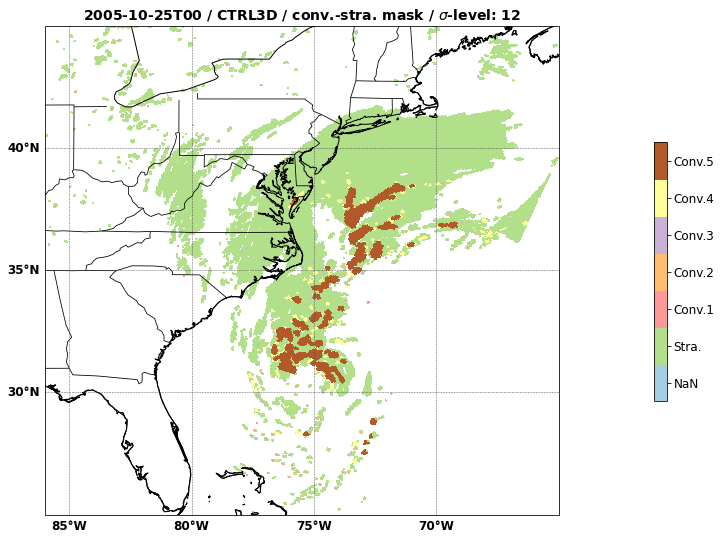

In [22]:
fig = plt.figure(figsize=(12,9))
ax1 = new_map(fig)
# ax1 = plt.axes(projection = ccrs.LambertConformal(central_longitude=-100, central_latitude=40))
# ax1 = plt.axes(projection = ccrs.PlateCarree())

# cs[cs<0] = np.nan
# cc[cc<0] = np.nan

# plotting_var = cs
plotting_var = CS_mask
plotting_lon = dbz_sigmalev.XLONG
plotting_lat = dbz_sigmalev.XLAT

cf1 = ax1.pcolormesh( plotting_lon, plotting_lat, plotting_var
                    , cmap=plt.cm.get_cmap('Paired', 7)
                    , vmin=-1
                    , vmax=5
                    , shading='auto'
                    )
cf1.cmap.set_under('w')

## Title:
cf1_title = plt.title( np.datetime_as_string(dbz_sigmalev.Time.data, unit='h') + ' / '
                     + wrf_sim_type + ' / '
                     + 'conv.-stra. mask / '
                     + '$\sigma$-level: 12' # + str(interp_vertical_lev)
                     ,fontsize=14 
                     ,fontweight='bold'
                     # ,loc='left'
                     )
# plt.title('right', loc='right')

## Colorbar:
cbar_ax = fig.add_axes([0.92, 0.3, 0.015, 0.4])
cbar = fig.colorbar(cf1, 
                    cax=cbar_ax, 
                    fraction=0.04, 
                    ticks=np.arange(-1, 6, 1), 
                    boundaries=np.arange(-1.5, 6.5, 1))
cbar.ax.tick_params(labelsize=12)
cbar.set_ticklabels(['NaN', 'Stra.', 'Conv.1', 'Conv.2', 'Conv.3', 'Conv.4', 'Conv.5'])
# cbar_title = plt.title('[dBZ]', fontsize=12, y=-0.1)


# Save figure:
plt.savefig('./' + np.datetime_as_string(dbz_sigmalev.Time.data, unit='h') + '_CSmask_sigma.png', 
            bbox_inches='tight', 
            dpi=300)


